# Project 3
## Task 2: Shallow Anomaly Detection - Supervised vs Unsupervised

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import seaborn as sns

from sklearn.svm import OneClassSVM

from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.metrics import confusion_matrix


import torch
import random


In [26]:
# ============================================================================
# REPORT-COMPLIANT PLOT CONFIGURATION
# ============================================================================
# Set consistent style for all plots
plt.style.use('seaborn-v0_8-whitegrid')

# Global matplotlib parameters for report-quality figures
plt.rcParams.update({
    # Figure size (width, height) in inches - suitable for reports
    'figure.figsize': (8, 5),
    'figure.dpi': 150,

    # Font sizes
    'font.size': 13,
    'axes.titlesize': 15,
    'axes.labelsize': 15,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 13,
    'legend.title_fontsize': 11,

    # Font weight
    'axes.titleweight': 'bold',
    'axes.labelweight': 'bold',

    # Line widths
    'axes.linewidth': 1.2,
    'grid.linewidth': 0.8,
    'lines.linewidth': 1.5,

    # Grid style
    'grid.alpha': 0.3,
    'grid.linestyle': '--',

    # Save figure settings
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1,
})

# Color palette for consistency
REPORT_COLORS = {
    'primary': '#2E86AB',
    'secondary': '#A23B72',
    'tertiary': '#F18F01',
    'quaternary': '#C73E1D',
    'normal': '#2E86AB',
    'anomaly': '#F18F01'
}
# ============================================================================

## Helper functions

In [68]:
# ============================================================================
# GLOBAL CONFIGURATION: Plot Saving
# ============================================================================
SAVE_PLOTS = False
# ============================================================================

REPORT_IMAGES_DIR = '../Plots/Task2'
os.makedirs(REPORT_IMAGES_DIR, exist_ok=True)

def save_figure_for_report(filename, dpi=300, bbox_inches='tight'):
    """
    Persist the current matplotlib figure under the Task 2 plots directory.

    Args:
        filename: Target filename such as 'task2_ocsvm_confusion_matrix.png'.
        dpi: Output resolution (defaults to 300).
        bbox_inches: Matplotlib bounding box mode (defaults to 'tight').
    """
    if not SAVE_PLOTS or not filename:
        return

    filepath = os.path.join(REPORT_IMAGES_DIR, filename)
    plt.savefig(filepath, dpi=dpi, bbox_inches=bbox_inches)
    print(f"Figure saved to: {filepath}")

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"The device is set to: {device}")

The device is set to: cpu


In [5]:
# Seed al the libraries to ensure reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # for multi-GPU setups

# Example: setting a seed for reproducibility
set_seed(42)

In [6]:
def print_combined_classification_reports(y_true_train, y_pred_train,
                                         y_true_val, y_pred_val,
                                         y_true_test, y_pred_test):
    """
    Print classification reports for train, validation, and test sets in a compact format.

    Args:
        y_true_train, y_pred_train: True and predicted labels for training set
        y_true_val, y_pred_val: True and predicted labels for validation set
        y_true_test, y_pred_test: True and predicted labels for test set
        class_names: List of class names
    """

    # Calculate metrics for each set
    train_prec, train_rec, train_f1, train_support = precision_recall_fscore_support(y_true_train, y_pred_train, average=None, zero_division=0)
    val_prec, val_rec, val_f1, val_support = precision_recall_fscore_support(y_true_val, y_pred_val, average=None, zero_division=0)
    test_prec, test_rec, test_f1, test_support = precision_recall_fscore_support(y_true_test, y_pred_test, average=None, zero_division=0)

    train_acc = accuracy_score(y_true_train, y_pred_train)
    val_acc = accuracy_score(y_true_val, y_pred_val)
    test_acc = accuracy_score(y_true_test, y_pred_test)

    # Print compact report
    print("\n" + "="*125)
    print("CLASSIFICATION REPORT: Train / Validation / Test")
    print("="*125)
    print(f"{'Class':<20} {'Precision':<25} {'Recall':<25} {'F1-Score':<25} {'Support':<25}")
    print(f"{'':20} {'Train Val  Test':<25} {'Train Val  Test':<25} {'Train Val  Test':<25} {'Train  Val   Test':<25}")
    print("-"*125)

    for idx in range(2):
        print(f"{idx:<20}"
              f"{train_prec[idx]:>5.2f} {val_prec[idx]:>5.2f} {test_prec[idx]:>5.2f}\t      "
              f"{train_rec[idx]:>5.2f} {val_rec[idx]:>5.2f} {test_rec[idx]:>5.2f}\t\t"
              f"{train_f1[idx]:>5.2f} {val_f1[idx]:>5.2f} {test_f1[idx]:>5.2f}\t   "
              f"{train_support[idx]:>5} {val_support[idx]:>5} {test_support[idx]:>5}")

    print("-"*125)
    print(f"{'Accuracy':<20}{train_acc:>5.2f} {val_acc:>5.2f} {test_acc:>5.2f}")
    print("="*125)


In [7]:
def plot_confusion_matrices_combined(y_true_list, y_pred_list, class_names, titles, save_name=None):
    """
    Creates a combined figure with multiple confusion matrices in one row.

    Args:
        y_true_list: List of true labels arrays [train, val, test]
        y_pred_list: List of predicted labels arrays [train, val, test]
        class_names: List of class names for axis labels
        titles: List of titles for each subplot
        save_name: Optional filename for the consolidated confusion matrices.
    """
    fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))

    for idx, (y_true, y_pred, title, ax) in enumerate(zip(y_true_list, y_pred_list, titles, axes)):
        cm = confusion_matrix(y_true, y_pred)

        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={'size': 10},
                   xticklabels=class_names, yticklabels=class_names,
                   ax=ax, cbar_kws={'label': 'Count'})

        ax.set_xlabel("Predicted Label")
        ax.set_ylabel("True Label")
        ax.set_title(title, fontsize=11, fontweight='bold', pad=10)
        ax.tick_params(labelsize=9)

    plt.tight_layout()
    if save_name:
        save_figure_for_report(save_name)
    plt.show()

### Load the datasets preprocessed in Task 1

In [8]:
df_train = pd.read_csv('../data/preprocessed/train_preprocessed.csv')
df_val = pd.read_csv('../data/preprocessed/val_preprocessed.csv')
df_test = pd.read_csv('../data/preprocessed/test_preprocessed.csv')

In [61]:
all_labels = ['dos', 'normal', 'probe', 'r2l']

In [10]:
df_train_normal_only = df_train[df_train["binary_label"]==0].copy()
X_train_normal_only = df_train_normal_only.drop(columns=['label', 'binary_label'])
y_train_normal_only = list(df_train_normal_only['binary_label'])

X_train = df_train.drop(columns=['label', 'binary_label'])
y_original_train = list(df_train['label'])
y_train = list(df_train['binary_label'])

X_val = df_val.drop(columns=['label', 'binary_label'])
y_original_val = list(df_val['label'])
y_val = list(df_val['binary_label'])

X_test = df_test.drop(columns=['label', 'binary_label'])
y_original_test = list(df_test['label'])
y_test = list(df_test['binary_label'])

### Dataset Overview for Task 2

Before training the OC-SVM models, we examine the class distribution in our datasets. Understanding the balance between normal and anomalous samples is crucial for setting the `nu` parameter and interpreting model performance.

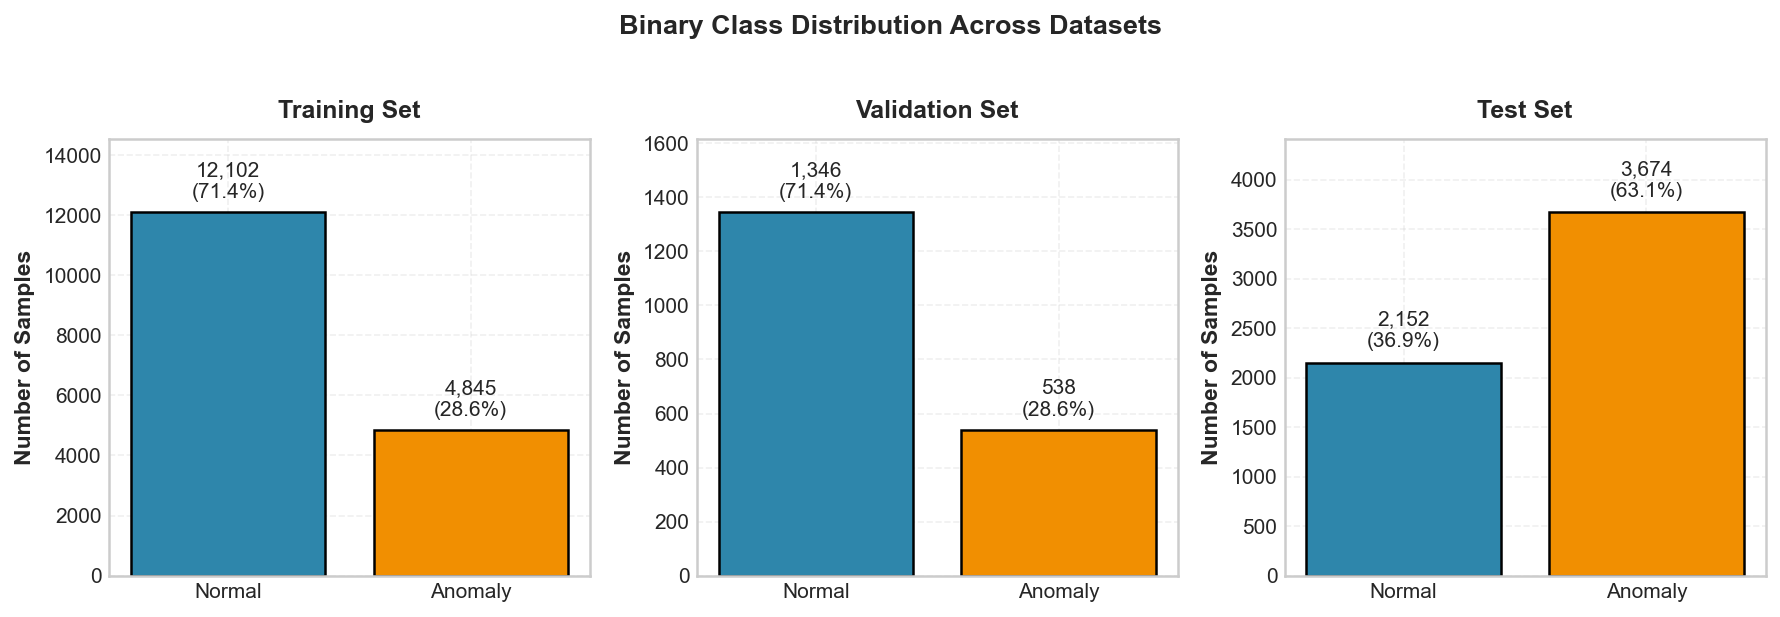


DATASET SUMMARY
Training Set         | Total: 16,947 | Normal: 12,102 ( 71.4%) | Anomaly:  4,845 ( 28.6%)
Validation Set       | Total:  1,884 | Normal:  1,346 ( 71.4%) | Anomaly:    538 ( 28.6%)
Test Set             | Total:  5,826 | Normal:  2,152 ( 36.9%) | Anomaly:  3,674 ( 63.1%)


In [11]:
# ============================================================================
# DATASET CLASS DISTRIBUTION
# ============================================================================
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

datasets = [
    (df_train, 'Training Set'),
    (df_val, 'Validation Set'),
    (df_test, 'Test Set')
]

for ax, (df, title) in zip(axes, datasets):
    class_counts = df['binary_label'].value_counts().sort_index()
    colors = [REPORT_COLORS['normal'], REPORT_COLORS['anomaly']]
    labels = ['Normal', 'Anomaly']

    bars = ax.bar(labels, class_counts.values, color=colors, edgecolor='black', linewidth=1.2)

    # Add count and percentage labels on bars
    total = class_counts.sum()
    for bar, count in zip(bars, class_counts.values):
        percentage = count / total * 100
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + total*0.02,
                f'{count:,}\n({percentage:.1f}%)', ha='center', va='bottom', fontsize=10)

    ax.set_title(title, fontsize=12, fontweight='bold', pad=10)
    ax.set_ylabel('Number of Samples')
    ax.set_ylim(0, class_counts.max() * 1.2)

plt.suptitle('Binary Class Distribution Across Datasets', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
save_figure_for_report('task2_class_distribution.png')
plt.show()

# Print summary statistics
print("\n" + "="*70)
print("DATASET SUMMARY")
print("="*80)
for df, name in datasets:
    normal = (df['binary_label'] == 0).sum()
    anomaly = (df['binary_label'] == 1).sum()
    total = len(df)
    print(f"{name:20} | Total: {total:>6,} | Normal: {normal:>6,} ({normal/total*100:>5.1f}%) | Anomaly: {anomaly:>6,} ({anomaly/total*100:>5.1f}%)")
print("="*80)

### One Class SVM (Normal data only)
First, we train a One-Class Support Vector Machine (OC-SVM) with benign (normal) traffic (using different nu values), and evaluate its performance on the whole dataset (normal + anomalies).



=== Training One-Class SVM with nu=1e-05 ===

CLASSIFICATION REPORT: Train / Validation / Test
Class                Precision                 Recall                    F1-Score                  Support                  
                     Train Val  Test           Train Val  Test           Train Val  Test           Train  Val   Test        
-----------------------------------------------------------------------------------------------------------------------------
0                    0.93  0.91  0.70	       0.91  0.91  0.84		 0.92  0.91  0.76	   12102  1346  2152
1                    0.80  0.78  0.89	       0.84  0.78  0.79		 0.82  0.78  0.84	    4845   538  3674
-----------------------------------------------------------------------------------------------------------------------------
Accuracy             0.89  0.87  0.81


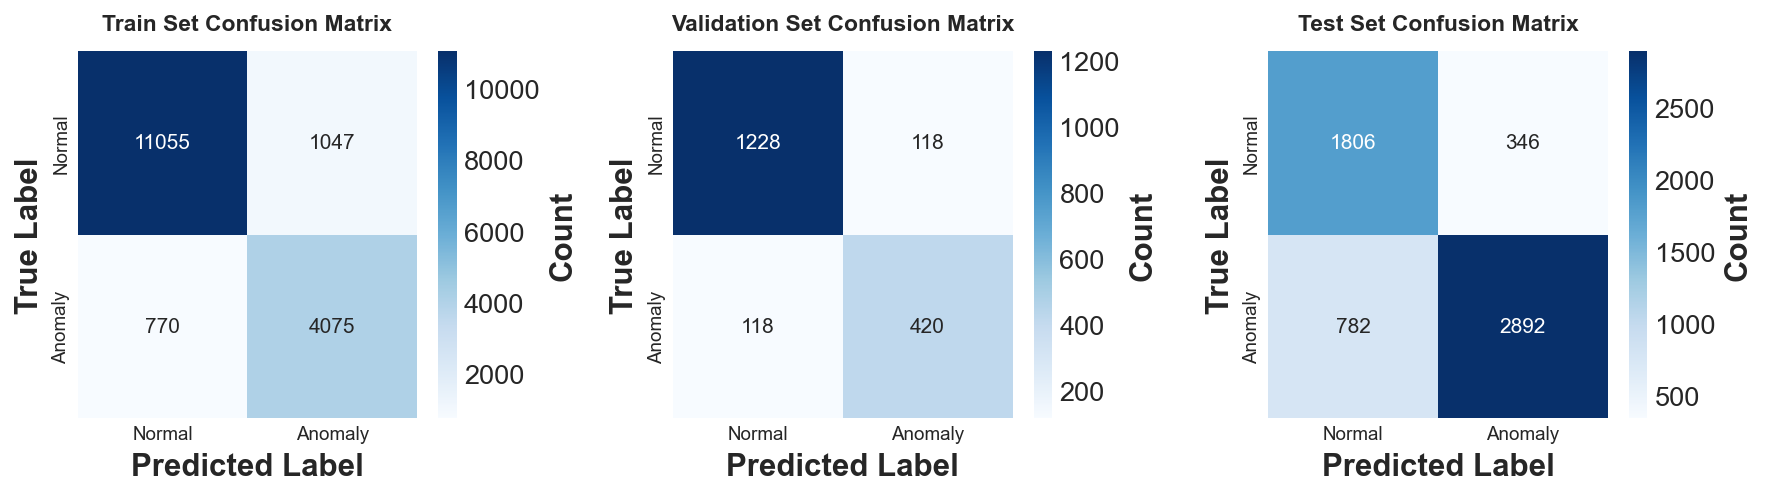



=== Training One-Class SVM with nu=0.0001 ===

CLASSIFICATION REPORT: Train / Validation / Test
Class                Precision                 Recall                    F1-Score                  Support                  
                     Train Val  Test           Train Val  Test           Train Val  Test           Train  Val   Test        
-----------------------------------------------------------------------------------------------------------------------------
0                    0.91  0.90  0.63	       0.99  0.99  0.75		 0.95  0.94  0.68	   12102  1346  2152
1                    0.98  0.96  0.84	       0.76  0.71  0.74		 0.86  0.82  0.79	    4845   538  3674
-----------------------------------------------------------------------------------------------------------------------------
Accuracy             0.93  0.91  0.74


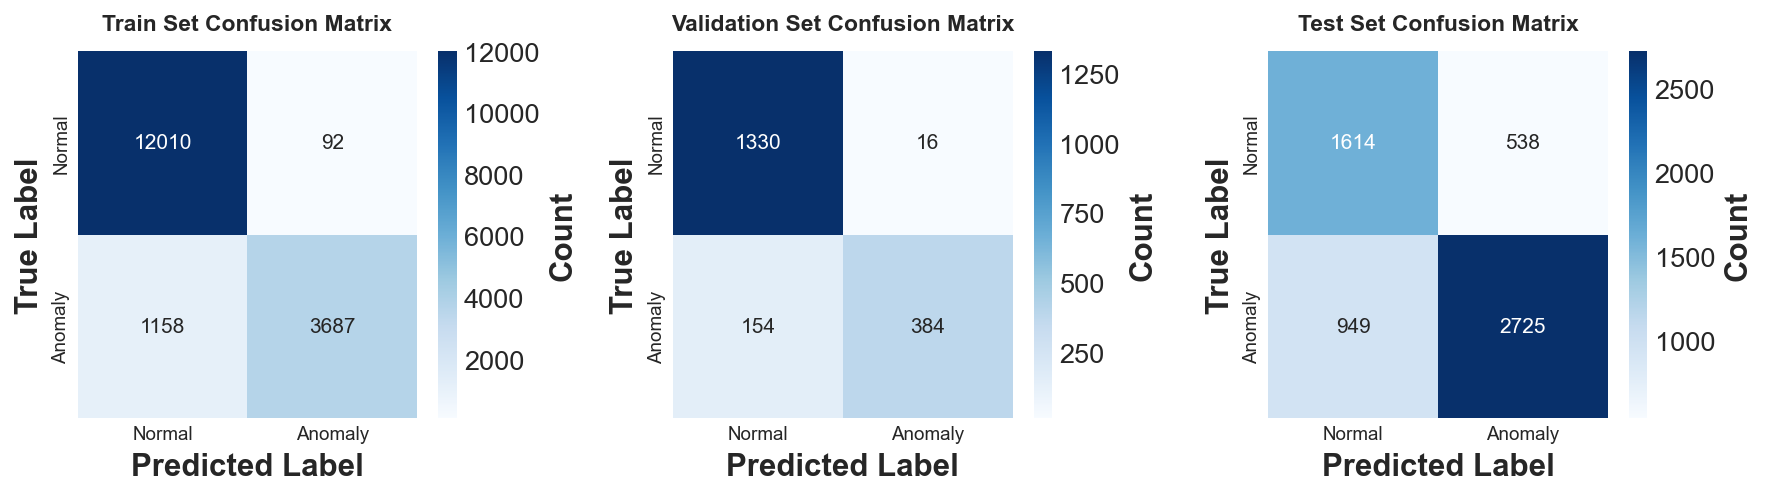



=== Training One-Class SVM with nu=0.001 ===

CLASSIFICATION REPORT: Train / Validation / Test
Class                Precision                 Recall                    F1-Score                  Support                  
                     Train Val  Test           Train Val  Test           Train Val  Test           Train  Val   Test        
-----------------------------------------------------------------------------------------------------------------------------
0                    0.91  0.90  0.63	       0.99  0.99  0.75		 0.95  0.94  0.68	   12102  1346  2152
1                    0.98  0.96  0.84	       0.76  0.71  0.74		 0.86  0.82  0.78	    4845   538  3674
-----------------------------------------------------------------------------------------------------------------------------
Accuracy             0.93  0.91  0.74


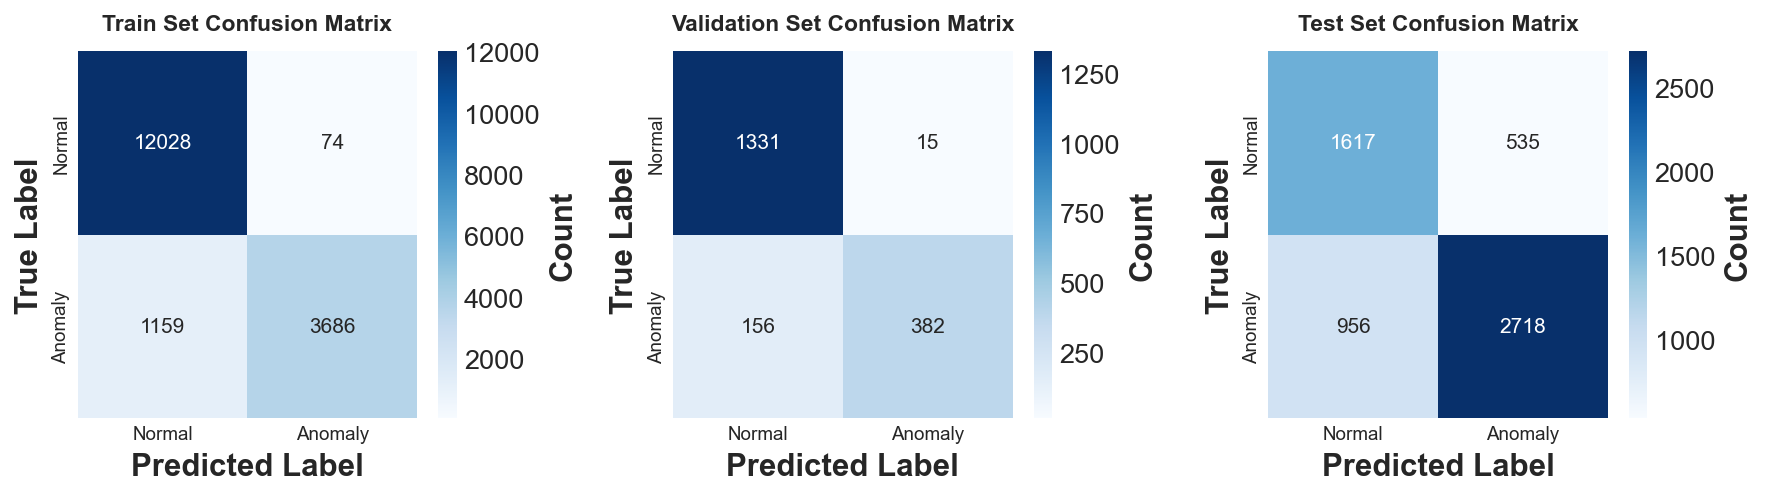



=== Training One-Class SVM with nu=0.01 ===

CLASSIFICATION REPORT: Train / Validation / Test
Class                Precision                 Recall                    F1-Score                  Support                  
                     Train Val  Test           Train Val  Test           Train Val  Test           Train  Val   Test        
-----------------------------------------------------------------------------------------------------------------------------
0                    0.91  0.89  0.63	       0.99  0.99  0.75		 0.95  0.94  0.68	   12102  1346  2152
1                    0.97  0.96  0.83	       0.76  0.71  0.74		 0.85  0.82  0.79	    4845   538  3674
-----------------------------------------------------------------------------------------------------------------------------
Accuracy             0.92  0.91  0.75


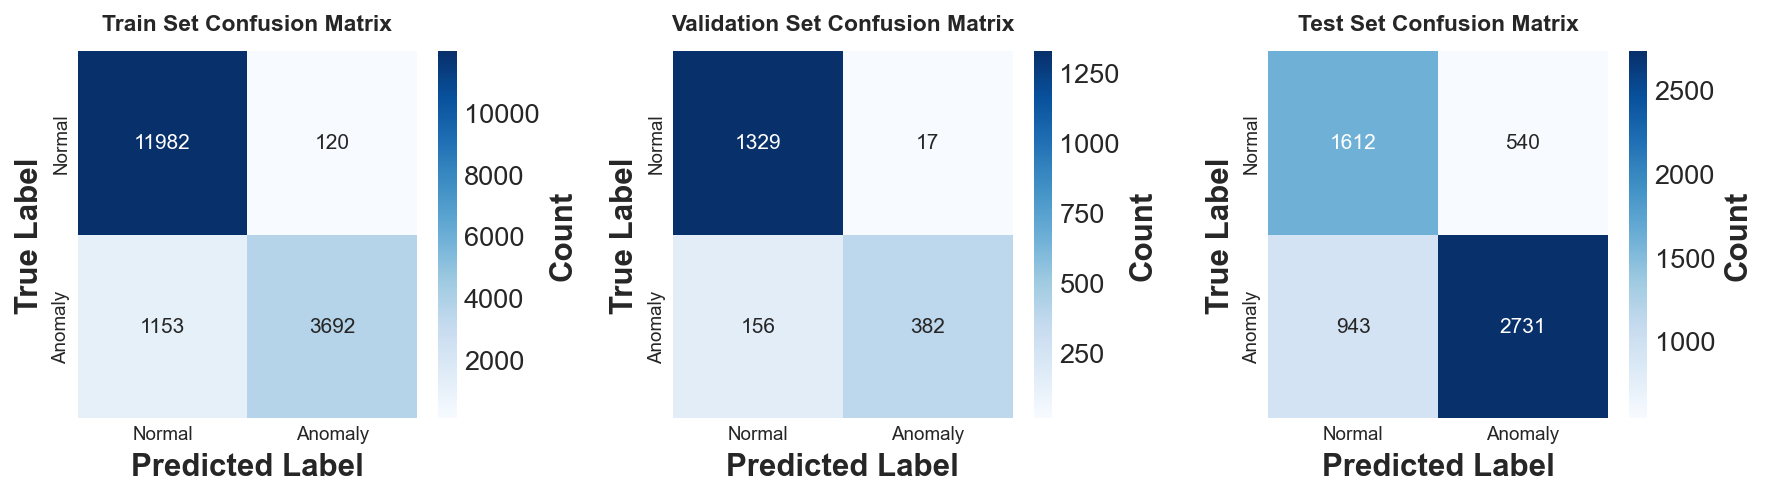



=== Training One-Class SVM with nu=0.5 ===

CLASSIFICATION REPORT: Train / Validation / Test
Class                Precision                 Recall                    F1-Score                  Support                  
                     Train Val  Test           Train Val  Test           Train Val  Test           Train  Val   Test        
-----------------------------------------------------------------------------------------------------------------------------
0                    0.99  0.99  0.76	       0.50  0.50  0.08		 0.66  0.67  0.15	   12102  1346  2152
1                    0.44  0.44  0.65	       0.99  0.99  0.98		 0.61  0.61  0.78	    4845   538  3674
-----------------------------------------------------------------------------------------------------------------------------
Accuracy             0.64  0.64  0.65


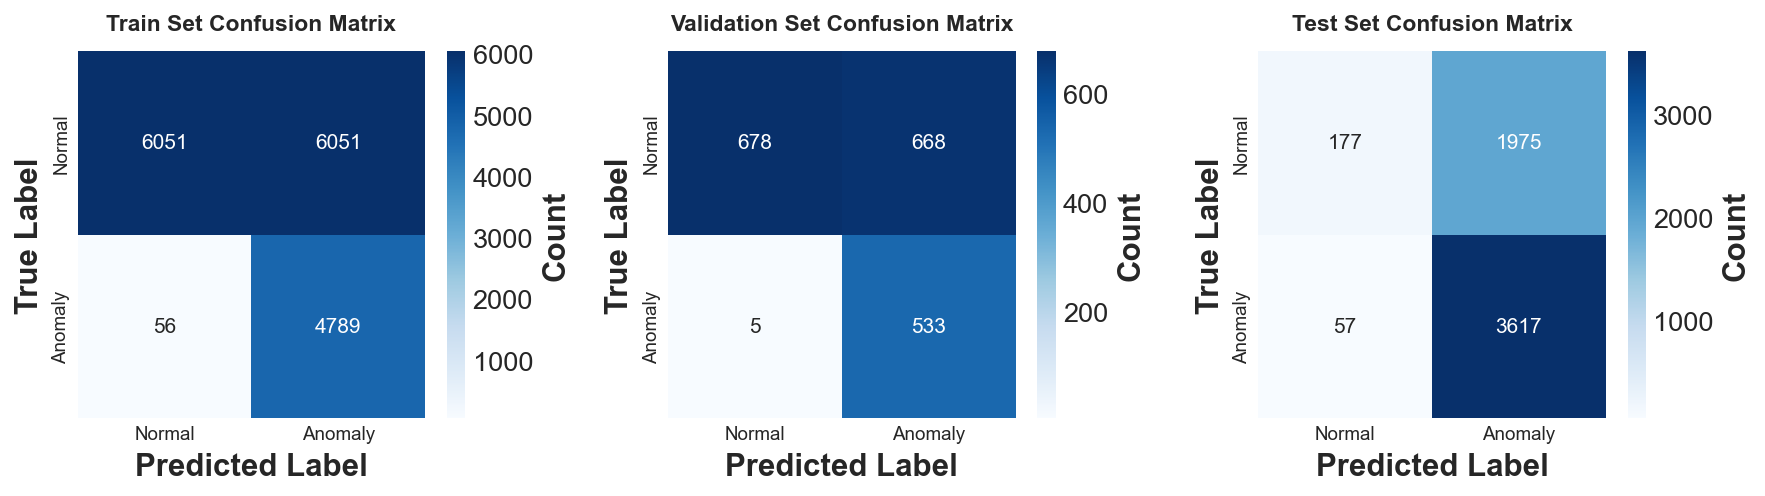

In [62]:
# 0.5 = the default value of nu
# 1e-4 and 1e-3 are two possible extimations
for nu in [0.00001, 0.0001, 0.001, 0.01, 0.5]:
    print(f"\n\n=== Training One-Class SVM with nu={nu} ===")
    # === 1. Fit One-Class SVM ===
    # Assume X_train is your input data (numpy array or DataFrame with features only)
    ocsvm_normal_only = OneClassSVM(kernel='rbf', gamma='scale', nu=nu)  # nu = expected anomaly proportion - only normal data
    ocsvm_normal_only.fit(X_train_normal_only)

    # === 2. Inference ===
    # Predict returns 1 for inliers, -1 for outliers
    # Convert to binary anomaly labels: 1 = anomaly, 0 = normal

    y_train_pred = ocsvm_normal_only.predict(X_train)
    y_train_pred_binary = (y_train_pred == -1).astype(int)

    y_val_pred = ocsvm_normal_only.predict(X_val)
    y_val_pred_binary = (y_val_pred == -1).astype(int)

    y_test_pred = ocsvm_normal_only.predict(X_test)
    y_test_pred_binary = (y_test_pred == -1).astype(int)

    print_combined_classification_reports(
    y_true_train=y_train, y_pred_train=y_train_pred_binary,
    y_true_val=y_val, y_pred_val=y_val_pred_binary,
    y_true_test=y_test, y_pred_test=y_test_pred_binary
    )

    plot_confusion_matrices_combined(
    y_true_list=[y_train, y_val, y_test],
    y_pred_list=[y_train_pred_binary, y_val_pred_binary, y_test_pred_binary],
    class_names=['Normal', 'Anomaly'],
    titles=['Train Set Confusion Matrix', 'Validation Set Confusion Matrix', 'Test Set Confusion Matrix'],
    save_name=f'task2_ocsvm_normal_only_nu_{nu}.png'
    )

### Question 1: Parameter Nu
**Q: Considering that you are currently training only on normal data, which is a good estimate for the parameter nu? What is the impact on training performance? Try both your estimate and the default value of nu.**

**Answer:**
- **Estimate for nu:** Since we are training on normal data only, `nu` corresponds to the upper bound on the fraction of training errors (normal samples incorrectly classified as anomalies) and a lower bound of the fraction of support vectors. Ideally, we want `nu` to be very small (e.g., 0.00001 or 0.001) to encompass most normal data, assuming the training set is clean.
- **Impact:**
    - A **small nu (0.00001, 0.001)** assumes most training data is normal, leading to a broader decision boundary. This usually results in high recall for the normal class but might miss subtle anomalies (lower precision for anomalies).
    - A **large nu (0.5)** (default value) forces the model to treat 50% of the training data as outliers. This results in a very tight boundary, causing many normal samples to be classified as anomalies (high False Positive rate), which is generally poor for this scenario.

### One Class SVM (With All data)
Now, we train the OC-SVM with both normal and anomalous data.

In [58]:
anomaly_proportion = sum(y_train) / len(y_train)
print("Number anomalies", sum(y_train))
print("Number of training data", len(y_train))

# === 1. Fit One-Class SVM ===
# Assume X_train is your input data (numpy array or DataFrame with features only)
ocsvm = OneClassSVM(kernel='rbf', gamma='scale', nu=anomaly_proportion)  # nu = estimated anomaly proportion
ocsvm.fit(X_train)

y_train_pred = ocsvm.predict(X_train)
y_train_pred_binary = (y_train_pred == -1).astype(int)

y_val_pred = ocsvm.predict(X_val)
y_val_pred_binary = (y_val_pred == -1).astype(int)

y_test_pred = ocsvm.predict(X_test)
y_test_pred_binary = (y_test_pred == -1).astype(int)

Number anomalies 4845
Number of training data 16947



CLASSIFICATION REPORT: Train / Validation / Test
Class                Precision                 Recall                    F1-Score                  Support                  
                     Train Val  Test           Train Val  Test           Train Val  Test           Train  Val   Test        
-----------------------------------------------------------------------------------------------------------------------------
0                    0.85  0.84  0.54	       0.85  0.84  0.60		 0.85  0.84  0.57	   12102  1346  2152
1                    0.63  0.61  0.75	       0.63  0.61  0.71		 0.63  0.61  0.73	    4845   538  3674
-----------------------------------------------------------------------------------------------------------------------------
Accuracy             0.79  0.78  0.67


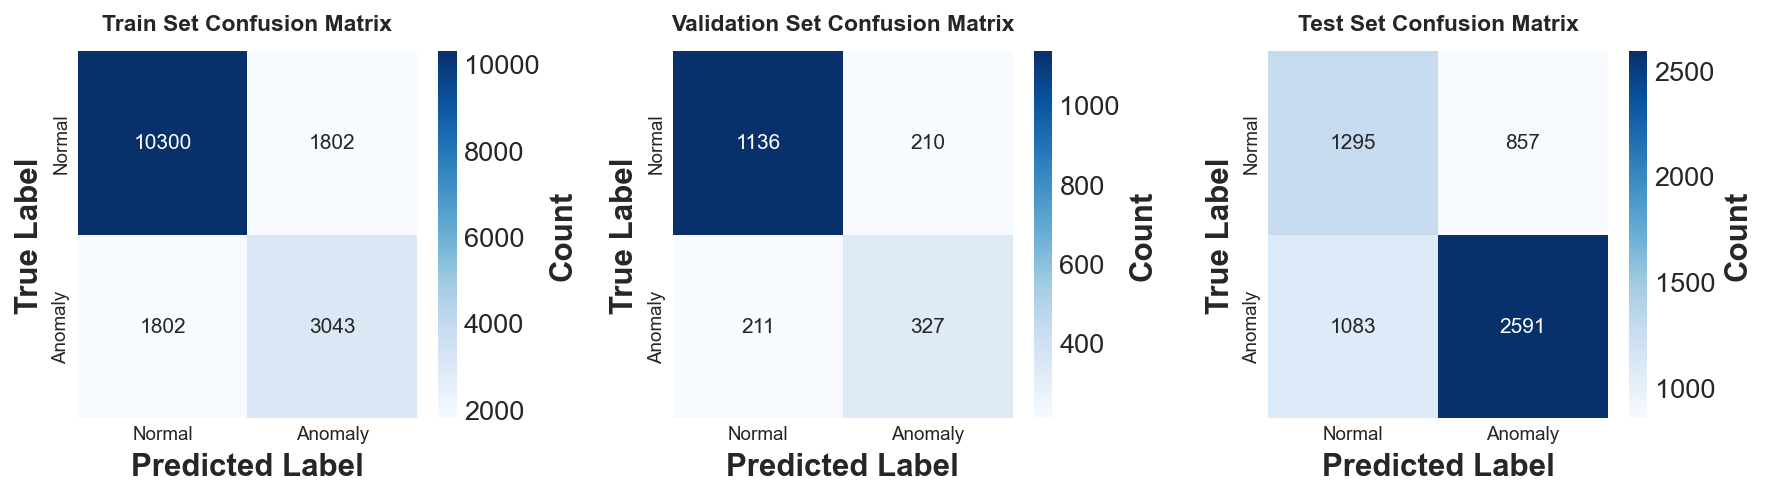

In [59]:
print_combined_classification_reports(
    y_true_train=y_train, y_pred_train=y_train_pred_binary,
    y_true_val=y_val, y_pred_val=y_val_pred_binary,
    y_true_test=y_test, y_pred_test=y_test_pred_binary
)

plot_confusion_matrices_combined(
    y_true_list=[y_train, y_val, y_test],
    y_pred_list=[y_train_pred_binary, y_val_pred_binary, y_test_pred_binary],
    class_names=['Normal', 'Anomaly'],
    titles=['Train Set Confusion Matrix', 'Validation Set Confusion Matrix', 'Test Set Confusion Matrix'],
    save_name='task2_ocsvm_all_data.png'
)

### Question 2: Model Comparison
**Q: Which model performs better? Why do you think that?**

**Answer:**
- Comparing the **Normal-Only OC-SVM** (with optimal `nu`) and the **All-Data OC-SVM**:
    - The **Normal-Only** model is often theoretically sounder for anomaly detection (Novelty Detection), as it learns the manifold of normal behavior without being influenced by specific anomalies.
    - The **All-Data** model (Outlier Detection) relies on `nu` to filter out the contamination. If `nu` accurately matches the contamination rate, it can perform well. However, if the anomalies in the training set are diverse or if `nu` is mismatched, it might learn a boundary that includes some anomalies or excludes too much normal data.
    - **Conclusion:** The Normal-Only model with a small `nu` is typically more robust for defining "normality", whereas the All-Data model's success depends heavily on the `nu` parameter matching the true anomaly ratio.

## One-Class SVM (with normal traffic and some anomalies)
Finally, we evaluate the impact of the percentage of anomalies while training the OC-SVM. We train several OC-SVMs with an increasing ratio of anomalous classes ([0%, 10%, 20%, 50%, 100% ] of anomalies).

In [15]:
# Create dataset with only anomalies (for mixing experiments)
df_train_anomalies_only = df_train[df_train["binary_label"]==1].copy()
df_train_anomalies_only = df_train_anomalies_only.drop(columns=['label', 'binary_label'])



=== Training One-Class SVM with 0% anomalies in training data ===

CLASSIFICATION REPORT: Train / Validation / Test
Class                Precision                 Recall                    F1-Score                  Support                  
                     Train Val  Test           Train Val  Test           Train Val  Test           Train  Val   Test        
-----------------------------------------------------------------------------------------------------------------------------
0                    0.91  0.90  0.63	       0.99  0.99  0.75		 0.95  0.94  0.68	   12102  1346  2152
1                    0.98  0.96  0.84	       0.76  0.71  0.74		 0.86  0.82  0.78	    4845   538  3674
-----------------------------------------------------------------------------------------------------------------------------
Accuracy             0.93  0.91  0.74


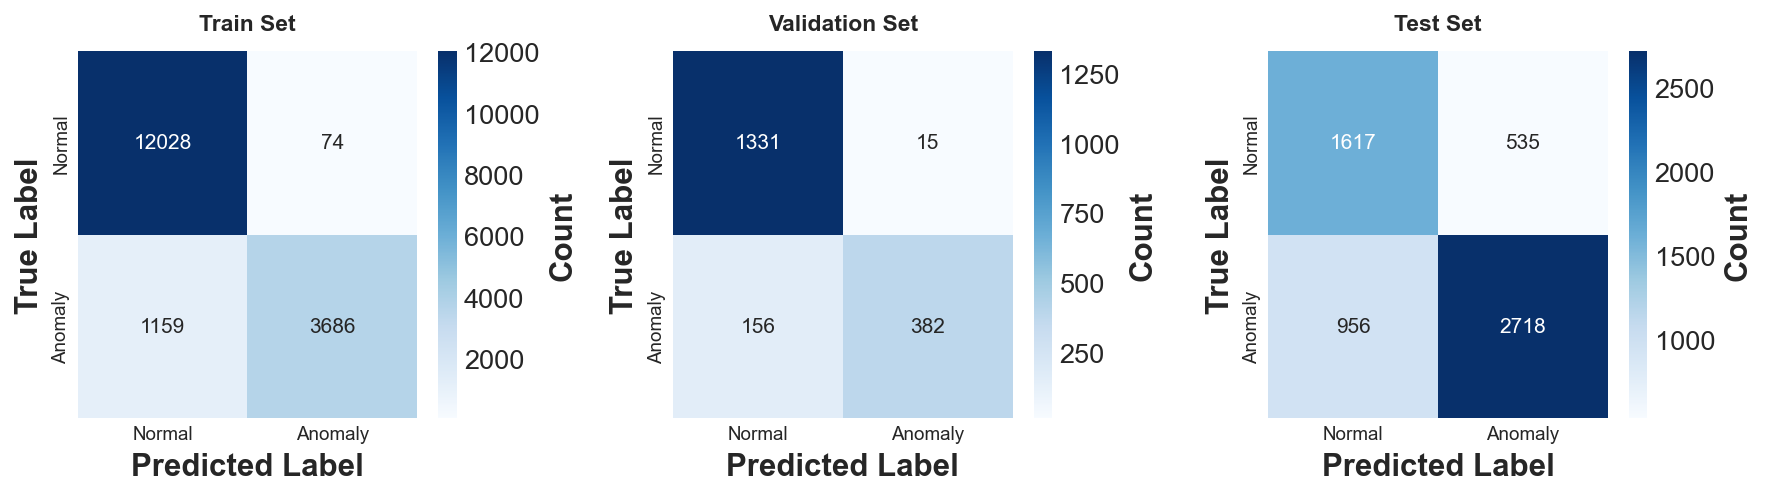



=== Training One-Class SVM with 10.0% anomalies in training data ===
NU =  0.03845542666454791

CLASSIFICATION REPORT: Train / Validation / Test
Class                Precision                 Recall                    F1-Score                  Support                  
                     Train Val  Test           Train Val  Test           Train Val  Test           Train  Val   Test        
-----------------------------------------------------------------------------------------------------------------------------
0                    0.77  0.76  0.39	       0.97  0.98  0.74		 0.86  0.86  0.51	   12102  1346  2152
1                    0.79  0.80  0.68	       0.26  0.25  0.32		 0.39  0.38  0.43	    4845   538  3674
-----------------------------------------------------------------------------------------------------------------------------
Accuracy             0.77  0.77  0.47


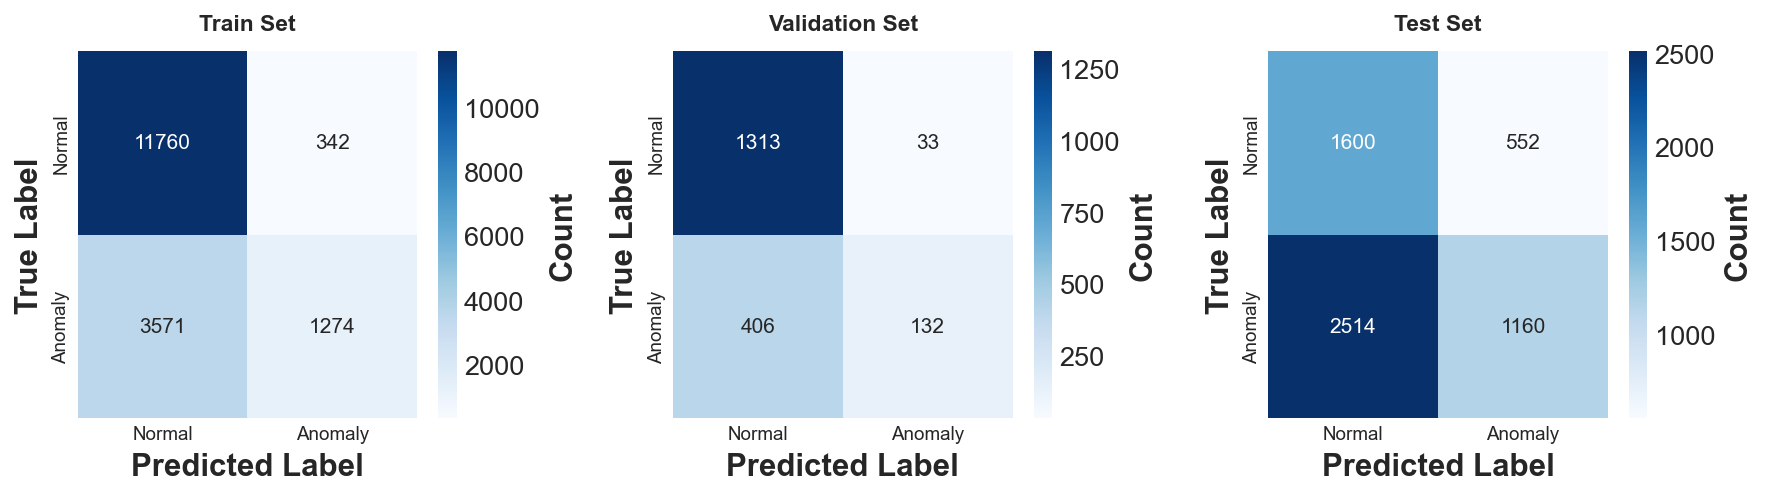



=== Training One-Class SVM with 20.0% anomalies in training data ===
NU =  0.07413357815010328

CLASSIFICATION REPORT: Train / Validation / Test
Class                Precision                 Recall                    F1-Score                  Support                  
                     Train Val  Test           Train Val  Test           Train Val  Test           Train  Val   Test        
-----------------------------------------------------------------------------------------------------------------------------
0                    0.79  0.78  0.42	       0.95  0.95  0.71		 0.86  0.86  0.53	   12102  1346  2152
1                    0.75  0.72  0.72	       0.37  0.33  0.43		 0.50  0.45  0.54	    4845   538  3674
-----------------------------------------------------------------------------------------------------------------------------
Accuracy             0.78  0.77  0.53


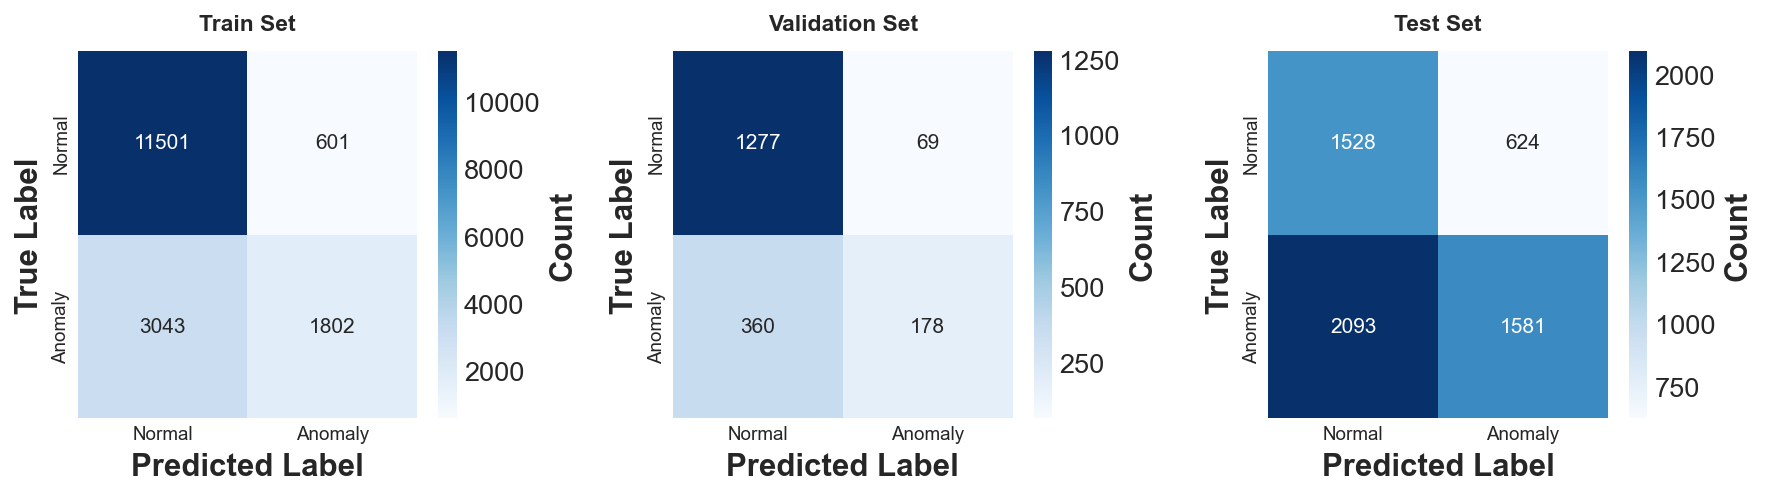



=== Training One-Class SVM with 50.0% anomalies in training data ===
NU =  0.16675846874139355

CLASSIFICATION REPORT: Train / Validation / Test
Class                Precision                 Recall                    F1-Score                  Support                  
                     Train Val  Test           Train Val  Test           Train Val  Test           Train  Val   Test        
-----------------------------------------------------------------------------------------------------------------------------
0                    0.82  0.82  0.49	       0.91  0.91  0.66		 0.86  0.86  0.56	   12102  1346  2152
1                    0.69  0.68  0.75	       0.52  0.50  0.60		 0.59  0.58  0.66	    4845   538  3674
-----------------------------------------------------------------------------------------------------------------------------
Accuracy             0.79  0.79  0.62


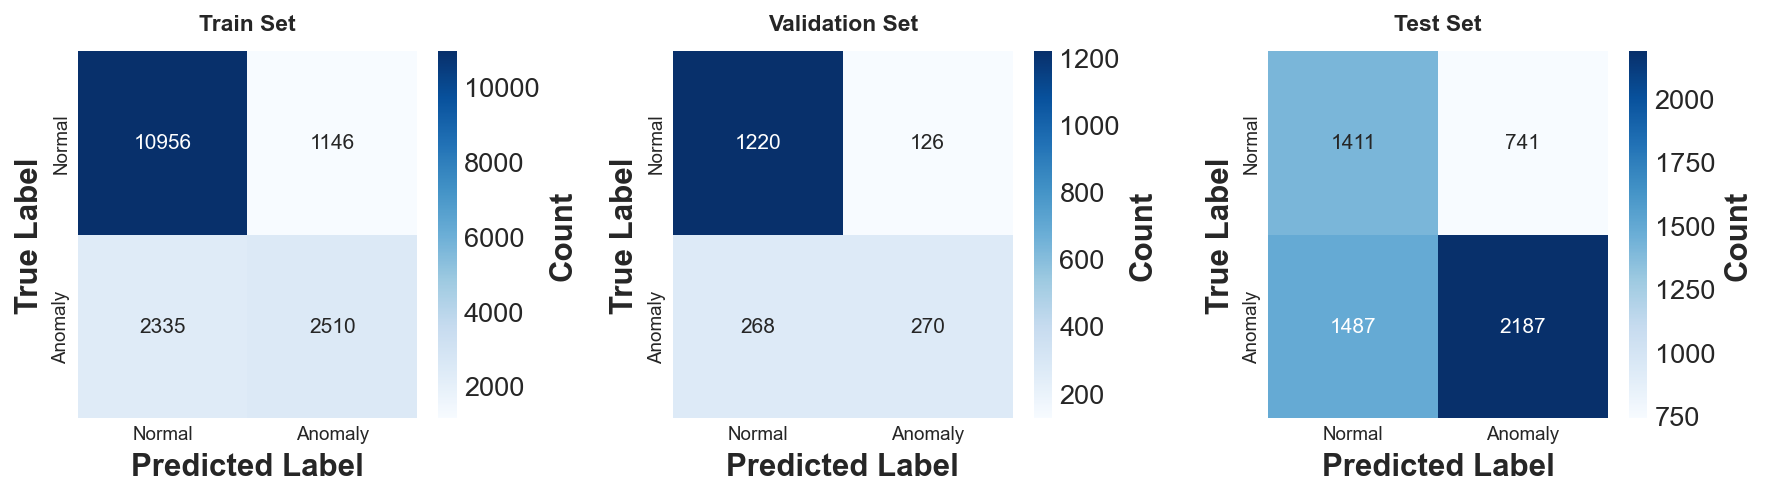



=== Training One-Class SVM with 100.0% anomalies in training data ===
NU =  0.2858913081961409

CLASSIFICATION REPORT: Train / Validation / Test
Class                Precision                 Recall                    F1-Score                  Support                  
                     Train Val  Test           Train Val  Test           Train Val  Test           Train  Val   Test        
-----------------------------------------------------------------------------------------------------------------------------
0                    0.85  0.84  0.54	       0.85  0.84  0.60		 0.85  0.84  0.57	   12102  1346  2152
1                    0.63  0.61  0.75	       0.63  0.61  0.71		 0.63  0.61  0.73	    4845   538  3674
-----------------------------------------------------------------------------------------------------------------------------
Accuracy             0.79  0.78  0.67


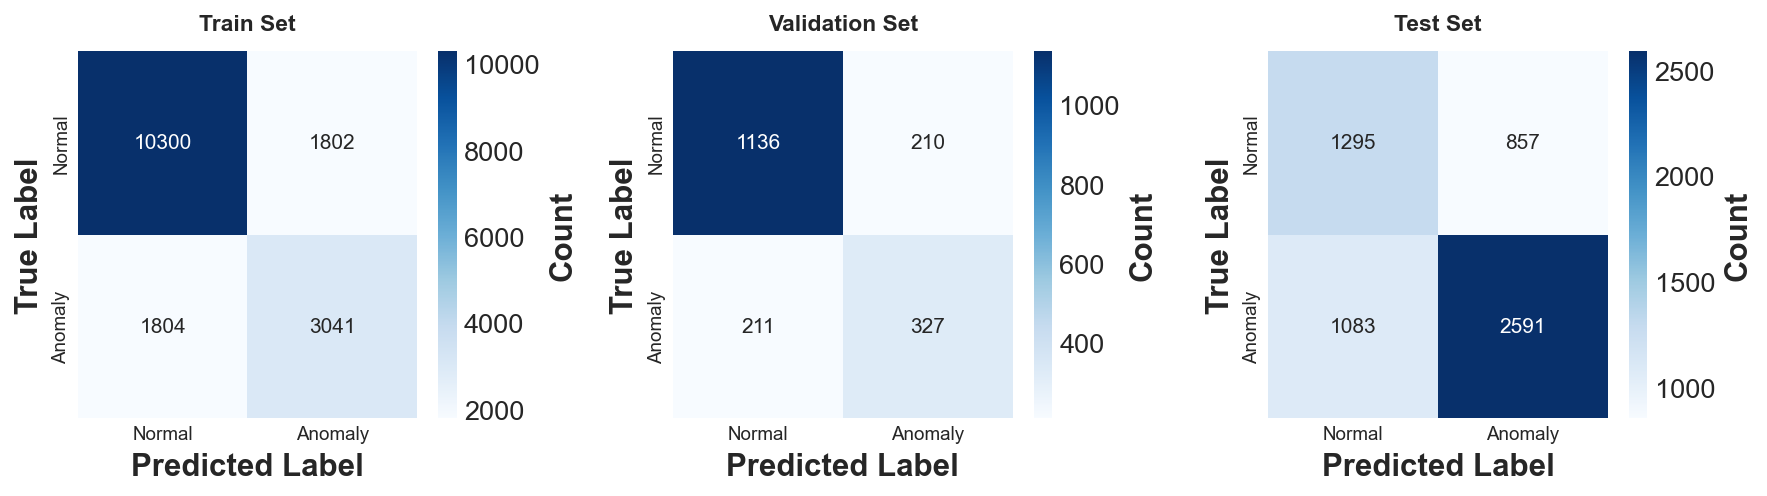

In [63]:
percentages = [0, 0.1, 0.2, 0.5, 1.0]
f1_scores_train = []
f1_scores_val = []
f1_scores_test = []

for p in percentages:
    print(f"\n\n=== Training One-Class SVM with {p*100}% anomalies in training data ===")

    subset = df_train_anomalies_only.sample(frac=p, random_state=42)
    df_train_mixed = pd.concat([X_train_normal_only, subset])

    if p == 0:
        nu = 0.001  # Small value to avoid nu=0
    else:
        nu = len(subset) / len(df_train_mixed)
        print("NU = ", nu)

    # === 1. Fit One-Class SVM ===
    # Assume X_train is your input data (numpy array or DataFrame with features only)
    ocsvm_p = OneClassSVM(kernel='rbf', gamma='scale', nu=nu)  # nu = estimated anomaly proportion
    ocsvm_p.fit(df_train_mixed)

    # === 2. Inference ===
    # Predict returns 1 for inliers, -1 for outliers
    # Convert to binary anomaly labels: 1 = anomaly, 0 = normal

    y_train_pred = ocsvm_p.predict(X_train)
    y_train_pred_binary = (y_train_pred == -1).astype(int)


    y_val_pred = ocsvm_p.predict(X_val)
    y_val_pred_binary = (y_val_pred == -1).astype(int)

    y_test_pred = ocsvm_p.predict(X_test)
    y_test_pred_binary = (y_test_pred == -1).astype(int)

    # Calculate F1 macro scores
    _, _, f1_train, _ = precision_recall_fscore_support(y_train, y_train_pred_binary, average='macro', zero_division=0)
    _, _, f1_val, _ = precision_recall_fscore_support(y_val, y_val_pred_binary, average='macro', zero_division=0)
    _, _, f1_test, _ = precision_recall_fscore_support(y_test, y_test_pred_binary, average='macro', zero_division=0)

    f1_scores_train.append(f1_train)
    f1_scores_val.append(f1_val)
    f1_scores_test.append(f1_test)

    print_combined_classification_reports(
    y_true_train=y_train, y_pred_train=y_train_pred_binary,
    y_true_val=y_val, y_pred_val=y_val_pred_binary,
    y_true_test=y_test, y_pred_test=y_test_pred_binary
    )

    plot_confusion_matrices_combined(
    y_true_list=[y_train, y_val, y_test],
    y_pred_list=[y_train_pred_binary, y_val_pred_binary, y_test_pred_binary],
    class_names=['Normal', 'Anomaly'],
    titles=['Train Set', 'Validation Set', 'Test Set'],
    save_name=f'task2_ocsvm_mixed_p_{int(p*100)}.png'
    )


Figure saved to: ../Plots/Task2/task2_f1_scores_vs_anomaly_percentage.png


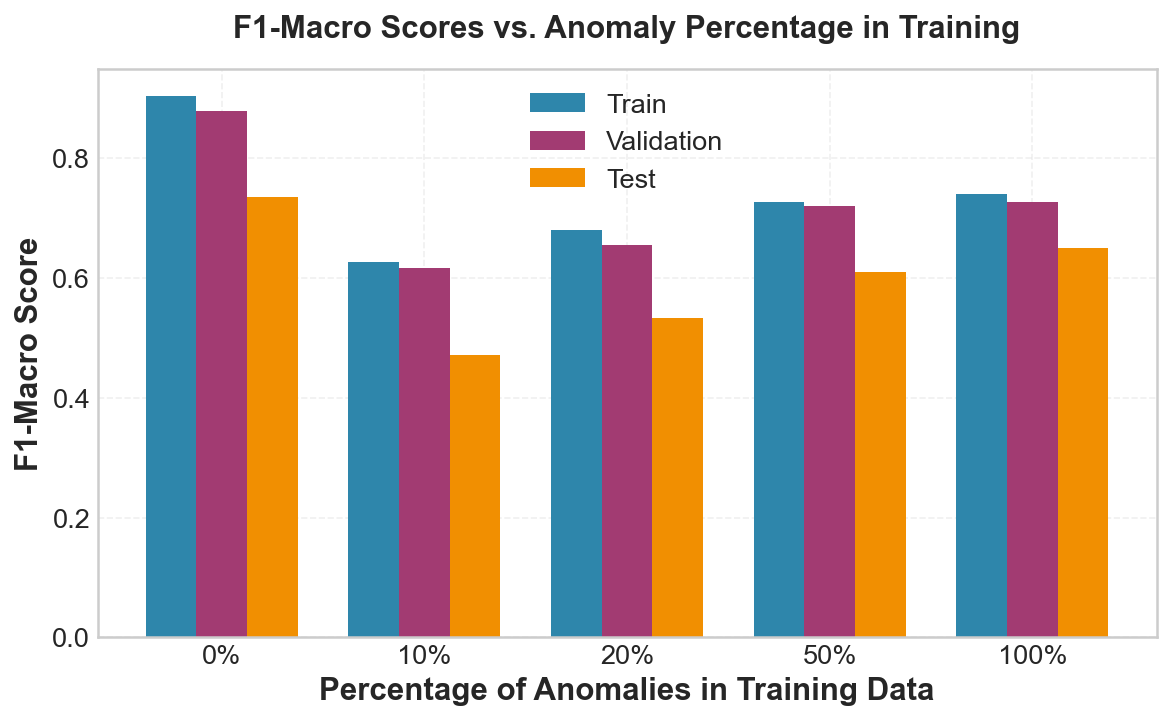

/var/folders/x0/vppspl391z3_qp7t8q5lczn00000gn/T/ipykernel_44192/654354605.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Figure saved to: ../Plots/Task2/task2_f1_scores_vs_anomaly_percentage_training.png


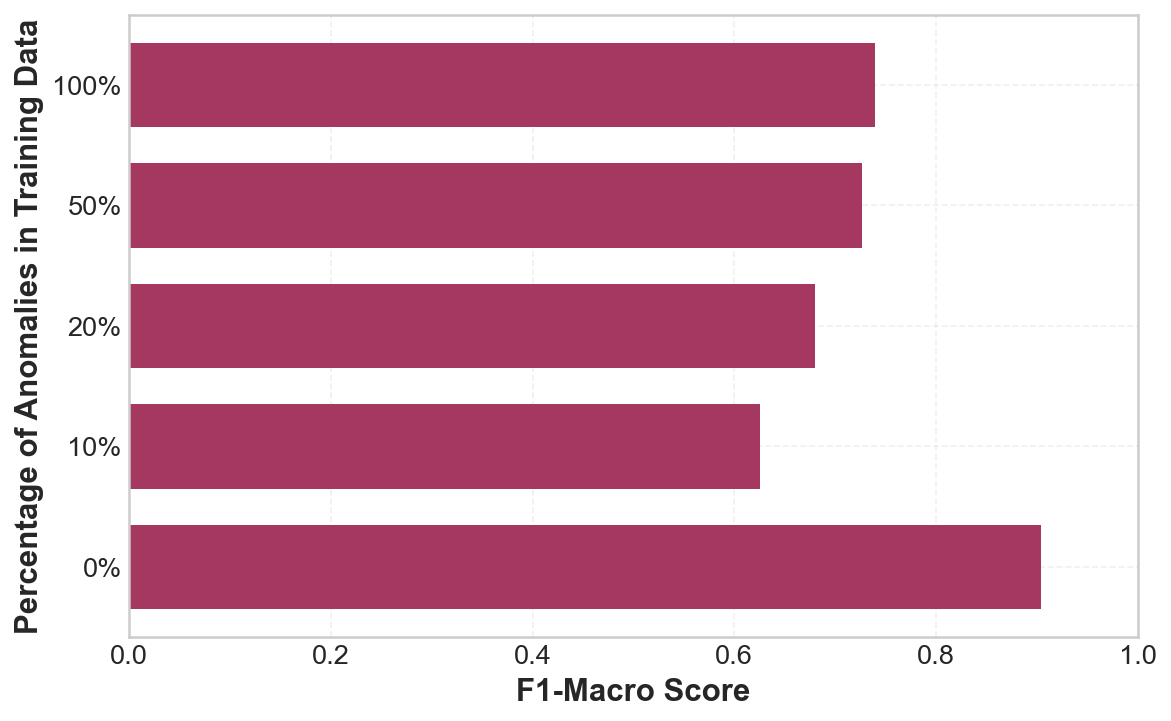

In [67]:
# Plot F1-macro scores
plt.figure(figsize=(8, 5))
x_labels = [f'{int(p*100)}%' for p in percentages]
x = np.arange(len(percentages))
width = 0.25

plt.bar(x - width, f1_scores_train, width, label='Train', color='#2E86AB')
plt.bar(x, f1_scores_val, width, label='Validation', color='#A23B72')
plt.bar(x + width, f1_scores_test, width, label='Test', color='#F18F01')

plt.xlabel('Percentage of Anomalies in Training Data')
plt.ylabel('F1-Macro Score')
plt.title('F1-Macro Scores vs. Anomaly Percentage in Training', pad=15)
plt.xticks(x, x_labels)
plt.legend()
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
save_figure_for_report('task2_f1_scores_vs_anomaly_percentage.png')
plt.show()

# Plot F1-macro scores
plt.figure(figsize=(8, 5))
y_labels = [f'{int(p*100)}%' for p in percentages]
x = np.arange(len(percentages))
width=0.7

#bar_colors = ['#caf0f8', '#90e0ef', '#00b4d8', '#0077b6', '#03045e']
plt.barh(x, f1_scores_train, width, color='#a53860')

plt.xlabel('F1-Macro Score')
plt.ylabel('Percentage of Anomalies in Training Data')
plt.yticks(x, y_labels)
plt.legend()
plt.xlim(0,1)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
save_figure_for_report('task2_f1_scores_vs_anomaly_percentage_training.png')
plt.show()

### Per-Attack Type Analysis

To answer **Question 4** properly and identify which attack type is most confused with normal traffic, we perform an analysis using the best-performing model (OC-SVM trained on normal data with `nu=0.001`). This helps understand the model's limitations on specific attack categories.

In [17]:
# ============================================================================
# PER-ATTACK TYPE CONFUSION ANALYSIS
# ============================================================================
# Train the best model: OC-SVM with normal data only and nu=0.001
best_ocsvm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.001)
best_ocsvm.fit(X_train_normal_only)

# Predict on test set
y_test_pred = best_ocsvm.predict(X_test)
y_test_pred_binary = (y_test_pred == -1).astype(int)

# Create a DataFrame with original labels and predictions
test_analysis = pd.DataFrame({
    'original_label': y_original_test,
    'binary_label': y_test,
    'predicted': y_test_pred_binary
})

# Calculate confusion rates per attack type
attack_analysis = []
for attack_type in test_analysis['original_label'].unique():
    subset = test_analysis[test_analysis['original_label'] == attack_type]
    total = len(subset)

    if all_labels[attack_type] == 'normal':
        # For normal traffic: how many were incorrectly flagged as anomalies (False Positives)
        incorrect = (subset['predicted'] == 1).sum()
        attack_analysis.append({
            'Attack Type': all_labels[attack_type],
            'Total Samples': total,
            'Correctly Classified': total - incorrect,
            'Misclassified': incorrect,
            'Misclassification Rate (%)': incorrect / total * 100,
            'Category': 'Normal'
        })
    else:
        # For attacks: how many were missed (False Negatives - predicted as normal)
        missed = (subset['predicted'] == 0).sum()
        attack_analysis.append({
            'Attack Type': all_labels[attack_type],
            'Total Samples': total,
            'Correctly Classified': total - missed,
            'Misclassified': missed,
            'Misclassification Rate (%)': missed / total * 100,
            'Category': 'Attack'
        })

attack_df = pd.DataFrame(attack_analysis)
attack_df = attack_df.sort_values('Misclassification Rate (%)', ascending=False)

print("="*80)
print("PER-ATTACK TYPE ANALYSIS (Best Model: OC-SVM nu=0.001, Normal-Only Training)")
print("="*80)
print(attack_df.to_string(index=False))
print("="*80)

PER-ATTACK TYPE ANALYSIS (Best Model: OC-SVM nu=0.001, Normal-Only Training)
Attack Type  Total Samples  Correctly Classified  Misclassified  Misclassification Rate (%) Category
        dos           2577                  1787            790                   30.655801   Attack
     normal           2152                  1617            535                   24.860595   Normal
      probe           1097                   931            166                   15.132179   Attack


/var/folders/x0/vppspl391z3_qp7t8q5lczn00000gn/T/ipykernel_44192/176766961.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right')


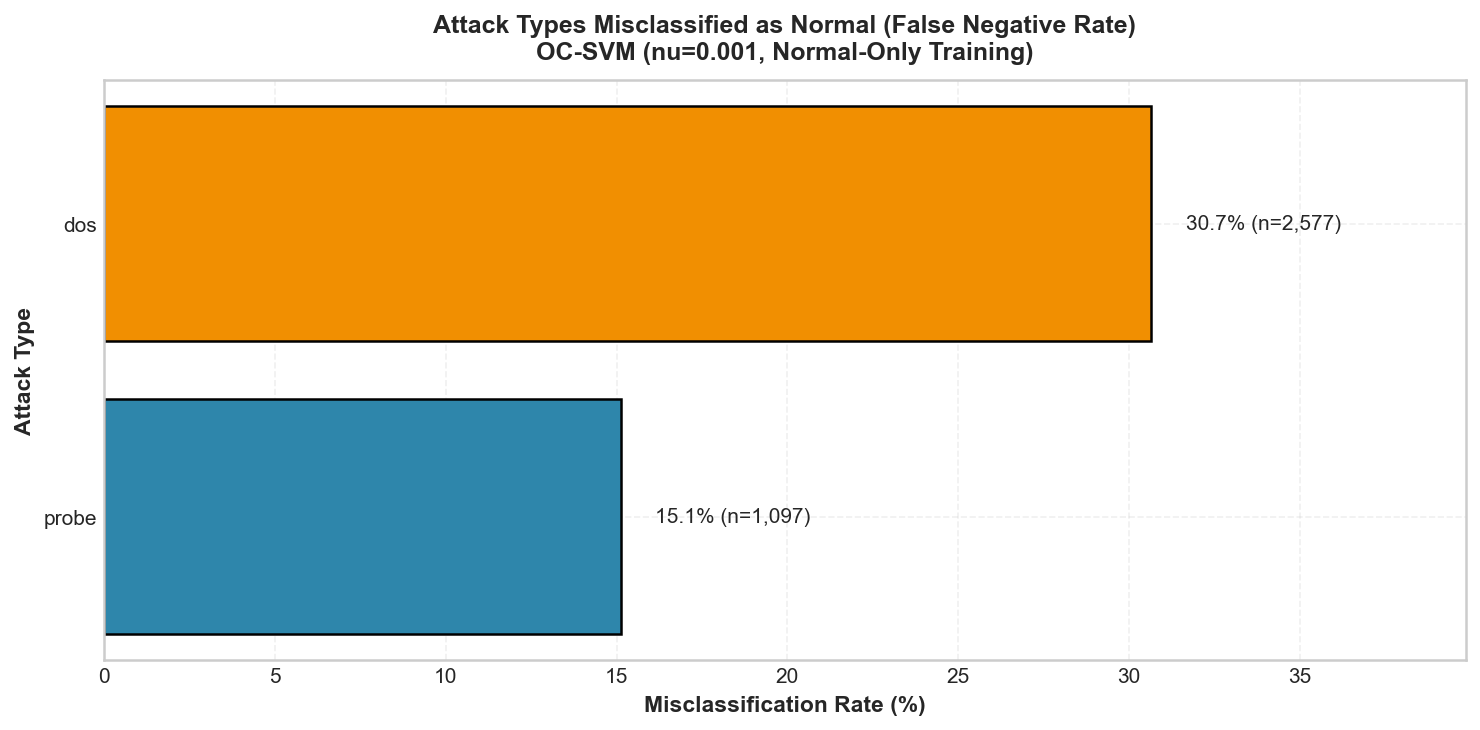


FINDING: The most confused attack type is 'dos' with 30.7% misclassified as normal.


In [18]:
# ============================================================================
# VISUALIZATION: Attack Misclassification Rates
# ============================================================================
# Filter to show only attack types (exclude normal for this plot)
attacks_only = attack_df[attack_df['Category'] == 'Attack'].copy()
attacks_only = attacks_only.sort_values('Misclassification Rate (%)', ascending=True)

fig, ax = plt.subplots(figsize=(10, 5))

colors = ['#2E86AB', '#F18F01']
bars = ax.barh(attacks_only['Attack Type'], attacks_only['Misclassification Rate (%)'],
               color=colors, edgecolor='black', linewidth=1.2)

# Add value labels on bars
for bar, rate, total in zip(bars, attacks_only['Misclassification Rate (%)'], attacks_only['Total Samples']):
    ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
            f'{rate:.1f}% (n={total:,})', va='center', fontsize=10)

ax.set_xlabel('Misclassification Rate (%)')
ax.set_ylabel('Attack Type')
ax.set_title('Attack Types Misclassified as Normal (False Negative Rate)\nOC-SVM (nu=0.001, Normal-Only Training)',
             fontsize=12, fontweight='bold', pad=10)
ax.set_xlim(0, max(attacks_only['Misclassification Rate (%)']) * 1.3)
ax.legend(loc='lower right')

plt.tight_layout()
save_figure_for_report('task2_attack_misclassification_rates.png')
plt.show()

# Identify most confused attack
most_confused = attacks_only.iloc[-1]  # After sorting ascending, last is highest
print(f"\nFINDING: The most confused attack type is '{most_confused['Attack Type']}' "
      f"with {most_confused['Misclassification Rate (%)']:.1f}% misclassified as normal.")

### Model Comparison Summary

This section consolidates all OC-SVM experiments to provide a clear comparison of model performance across different training configurations. This helps answer which model configuration achieves the best generalization on unseen test data.

In [ ]:
# ============================================================================
# MODEL COMPARISON: Train all configurations and collect metrics
# ============================================================================
from sklearn.metrics import precision_recall_fscore_support

model_results = []

# Helper function to evaluate a model
def evaluate_model(model, X_train, X_val, X_test, y_train, y_val, y_test, model_name):
    """Evaluate model and return metrics dictionary."""
    # Predict
    y_train_pred = (model.predict(X_train) == -1).astype(int)
    y_val_pred = (model.predict(X_val) == -1).astype(int)
    y_test_pred = (model.predict(X_test) == -1).astype(int)

    # Calculate metrics
    _, _, f1_train, _ = precision_recall_fscore_support(y_train, y_train_pred, average='macro', zero_division=0)
    _, _, f1_val, _ = precision_recall_fscore_support(y_val, y_val_pred, average='macro', zero_division=0)
    _, _, f1_test, _ = precision_recall_fscore_support(y_test, y_test_pred, average='macro', zero_division=0)

    return {
        'Model': model_name,
        'F1-Train': f1_train,
        'F1-Val': f1_val,
        'F1-Test': f1_test,
        'Train-Test Gap': abs(f1_train - f1_test)
    }

# 1. Normal-only models with different nu values
for nu in [0.00001, 0.001, 0.5]:
    model = OneClassSVM(kernel='rbf', gamma='scale', nu=nu)
    model.fit(X_train_normal_only)
    results = evaluate_model(model, X_train, X_val, X_test, y_train, y_val, y_test,
                            f'Normal-Only (nu={nu})')
    model_results.append(results)

# 2. All-data model
anomaly_prop = sum(y_train) / len(y_train)
model = OneClassSVM(kernel='rbf', gamma='scale', nu=anomaly_prop)
model.fit(X_train)
results = evaluate_model(model, X_train, X_val, X_test, y_train, y_val, y_test,
                        f'All-Data (nu={anomaly_prop:.3f})')
model_results.append(results)

# 3. Mixed models with varying anomaly percentages
for p in [0.1, 0.2, 0.5]:
    subset = df_train_anomalies_only.sample(frac=p, random_state=42)
    df_mixed = pd.concat([X_train_normal_only, subset])
    nu_mixed = len(subset) / len(df_mixed)

    model = OneClassSVM(kernel='rbf', gamma='scale', nu=nu_mixed)
    model.fit(df_mixed)
    results = evaluate_model(model, X_train, X_val, X_test, y_train, y_val, y_test,
                            f'Mixed ({int(p*100)}% anomalies)')
    model_results.append(results)

# Create comparison DataFrame
comparison_df = pd.DataFrame(model_results)
comparison_df = comparison_df.sort_values('F1-Test', ascending=False)

print("="*85)
print("MODEL COMPARISON SUMMARY - All OC-SVM Configurations")
print("="*85)
print(comparison_df.to_string(index=False))
print("="*85)
print(f"\nBEST MODEL (by Test F1): {comparison_df.iloc[0]['Model']} with F1-Test = {comparison_df.iloc[0]['F1-Test']:.4f}")

MODEL COMPARISON SUMMARY - All OC-SVM Configurations
                 Model  F1-Train   F1-Val  F1-Test  Train-Test Gap
Normal-Only (nu=1e-05)  0.870880 0.846501 0.799415        0.071464
Normal-Only (nu=0.001)  0.903977 0.878376 0.734600        0.169378
   All-Data (nu=0.286)  0.739585 0.726020 0.649674        0.089910
 Mixed (50% anomalies)  0.726717 0.719566 0.610669        0.116048
 Mixed (20% anomalies)  0.680242 0.654844 0.533604        0.146639
 Mixed (10% anomalies)  0.625864 0.616152 0.470720        0.155144
  Normal-Only (nu=0.5)  0.637632 0.640653 0.464535        0.173097

BEST MODEL (by Test F1): Normal-Only (nu=1e-05) with F1-Test = 0.7994


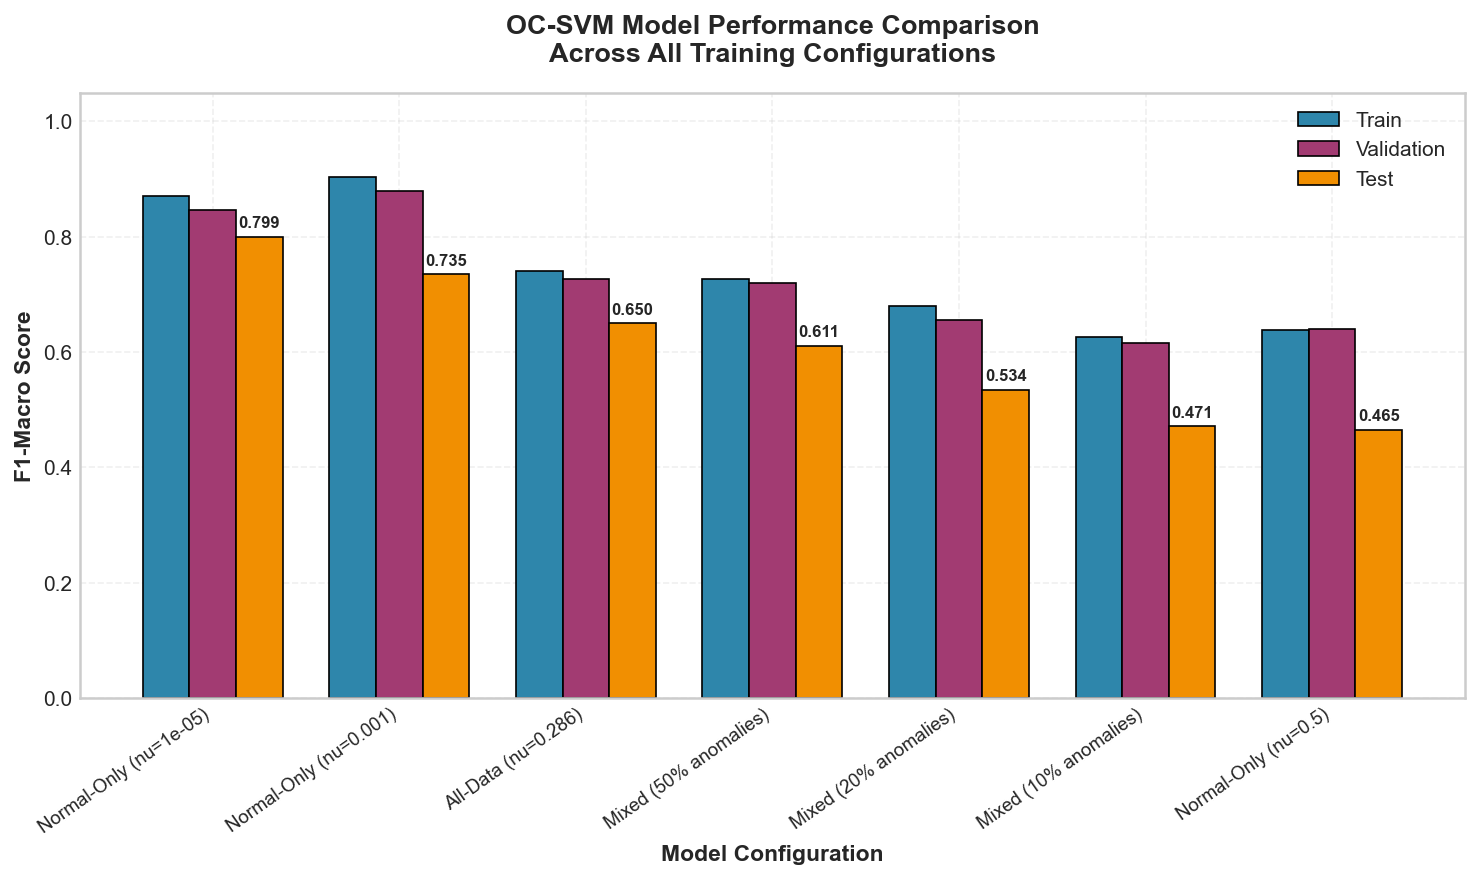

In [20]:
# ============================================================================
# VISUALIZATION: Model Performance Comparison
# ============================================================================
fig, ax = plt.subplots(figsize=(10, 6))

# Prepare data for grouped bar chart
models = comparison_df['Model'].tolist()
x = np.arange(len(models))
width = 0.25

# Create bars
bars_train = ax.bar(x - width, comparison_df['F1-Train'], width, label='Train',
                    color=REPORT_COLORS['primary'], edgecolor='black', linewidth=0.8)
bars_val = ax.bar(x, comparison_df['F1-Val'], width, label='Validation',
                  color=REPORT_COLORS['secondary'], edgecolor='black', linewidth=0.8)
bars_test = ax.bar(x + width, comparison_df['F1-Test'], width, label='Test',
                   color=REPORT_COLORS['tertiary'], edgecolor='black', linewidth=0.8)

# Customize plot
ax.set_xlabel('Model Configuration')
ax.set_ylabel('F1-Macro Score')
ax.set_title('OC-SVM Model Performance Comparison\nAcross All Training Configurations',
             fontsize=13, fontweight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=35, ha='right', fontsize=9)
ax.legend(loc='upper right')
ax.set_ylim(0, 1.05)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on test bars (most important)
for bar in bars_test:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
save_figure_for_report('task2_model_comparison.png')
plt.show()

### Question 3: Impact of Anomaly Ratio
**Q: Plot the f1-macro score for each scenario. How does the increasing ratio of anomalies affect the results?**

**Answer:**
- **Observation:** As the percentage of anomalies in the training set increases, the challenge for the OC-SVM changes.
    - With **0% anomalies**, the model learns a pure normal boundary.
    - As **anomalies increase**, if `nu` is adjusted to match the contamination (as done in the code: `nu = len(subset) / len(df_train_mixed)`), the model attempts to exclude that fraction of data.
    - **Effect:** If the anomalies form a distinct cluster, the model can successfully exclude them. However, if they overlap with normal data, the decision boundary might become distorted, potentially reducing the F1-score or increasing False Positives/Negatives. The stability of the F1-score across scenarios indicates the separability of the anomalies.

### Question 4: Robustness
**Q: Is the best-performing model in the training set also the best here? Does it confuse normal data with anomalies? Which attack is the most confused?**

**Answer:**
- **Robustness:** We evaluate this by looking at the Test Set results across the different models.
- **Best Model:** Often, the model that generalizes best is the one trained on clean normal data (or with very low contamination), as it doesn't overfit to the specific anomalies present in the training set.
- **Confusion:**
    - **Normal as Anomaly (False Positive):** Occurs if the boundary is too tight (high `nu`).
    - **Anomaly as Normal (False Negative):** Occurs if the boundary is too loose or if the attack mimics normal traffic.
    - **Most Confused Attack:** Typically, attacks like **Probe** or **DoS** (if low rate) might be confused with normal traffic if their feature signatures (e.g., duration, bytes) overlap with legitimate user behavior. The confusion matrix for the test set reveals which specific class (Normal vs Anomaly) suffers most.